In [1]:
from __future__ import print_function
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from skimage.transform import resize

import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable

In [2]:
import os
import sys
cwd = os.getcwd()
#add CIFAR10 data in the environment


#Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import utils
from torchvision import transforms
import torchvision.utils as vutils

Total dog pictures available: 120


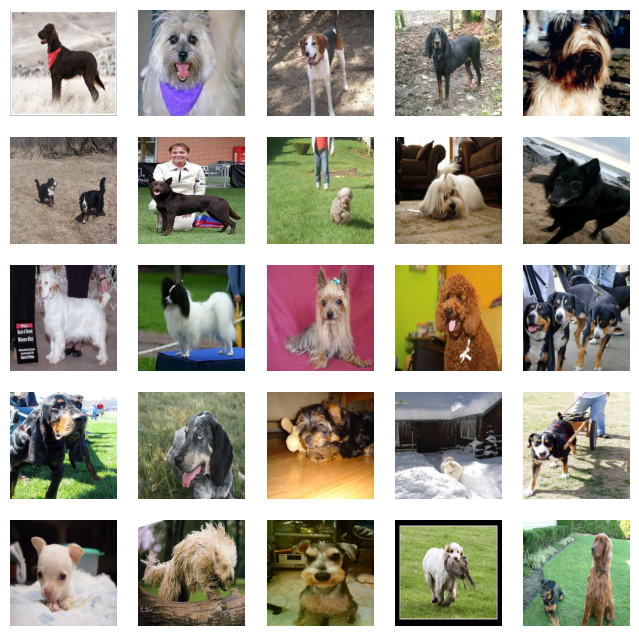

In [3]:
import random
# Define the path to the directory containing dog images
PATH = '/kaggle/input/stanford-dogs-dataset/images/Images/'

# Get the list of image filenames in the directory
images = os.listdir(PATH)

# Display the count of dog pictures in the directory
print(f'Total dog pictures available: {len(os.listdir(PATH))}')

# Create subplots to display random images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterate through the subplots and display random dog images
for indx, axis in enumerate(axes.flatten()):
    PATH_TEMP = random.choice(os.listdir(PATH))
    # Get a random index within the range of available images
    rnd_indx = np.random.randint(0, len(os.listdir(PATH+'/'+PATH_TEMP)))
    
    # Load and display the image using Matplotlib
    images = os.listdir(PATH+'/'+PATH_TEMP+'/')
    img = plt.imread(PATH+'/'+PATH_TEMP + '/'+images[rnd_indx])
    # Resize the image to a constant size (e.g., 64x64)
 
    img = resize(img, (400,400))
    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Turn off the axis for better visualization



In [4]:
batch_size = 32
image_size = 32

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(32),
                                transforms.CenterCrop(32),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Discriminator and Generator

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 3072
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 3072

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [6]:
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 32, 32)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def log_images(images, num_images, format='NCHW', normalize=True):
    '''
    input images are expected in format (NCHW)
    '''
    if type(images) == np.ndarray:
        images = torch.from_numpy(images)

    if format == 'NHWC':
        images = images.transpose(1, 3)

    

    # Make horizontal grid from image tensor
    horizontal_grid = vutils.make_grid(
        images, normalize=normalize, scale_each=True)
    # Make vertical grid from image tensor
    nrows = int(np.sqrt(num_images))
    grid = vutils.make_grid(
        images, nrow=nrows, normalize=True, scale_each=True)

    
    fig = plt.figure(figsize=(16, 16))
    plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
    plt.axis('off')
    if plot_horizontal:
        display.display(plt.gcf())
    plt.show()
    
def display_transposed_images_single_row(image_array):
    num_images = image_array.shape[0]

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for j in range(5):
        image = np.transpose(image_array[j].reshape((3, 32, 32)), (1, 2, 0))
        axes[j].imshow(image)
        axes[j].axis('off')

    plt.show()

In [7]:
def train_discriminator(discriminator, optimizer, real_data, fake_data, loss):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, Variable(torch.ones(N, 1)))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)))
    error_fake.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(discriminator, optimizer, fake_data, loss):
    # Reset gradients
    N = fake_data.size(0)  
    
    # Sample noise and generate fake data
    optimizer.zero_grad()  
    
    # Calculate error and backpropagate
    prediction = discriminator(fake_data)  
    error = loss(prediction, Variable(torch.ones(N, 1)))
    
    # Update weights with gradients
    error.backward()  
    optimizer.step()  
    
    # Return error
    return error

Epoch: [0/300], Batch Num: [0/644]
Discriminator Loss: 1.3930, Generator Loss: 0.6935
D(x): 0.4969, D(G(z)): 0.5002
------------------------------


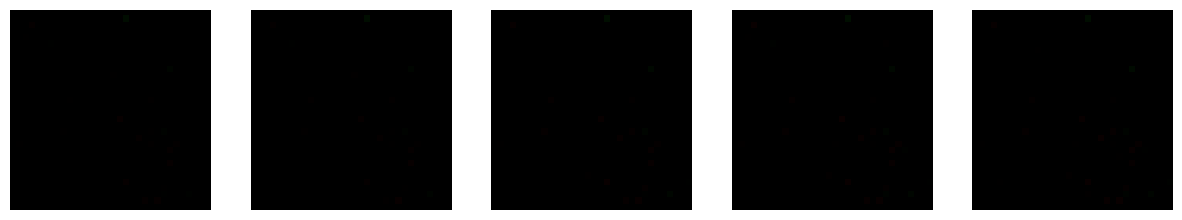

Epoch: [1/300], Batch Num: [0/644]
Discriminator Loss: 0.5126, Generator Loss: 2.8875
D(x): 0.9108, D(G(z)): 0.1003
------------------------------
Epoch: [2/300], Batch Num: [0/644]
Discriminator Loss: 0.0876, Generator Loss: 2.6508
D(x): 0.9967, D(G(z)): 0.0795
------------------------------
Epoch: [3/300], Batch Num: [0/644]
Discriminator Loss: 0.5739, Generator Loss: 2.0276
D(x): 0.8219, D(G(z)): 0.1847
------------------------------
Epoch: [4/300], Batch Num: [0/644]
Discriminator Loss: 1.6505, Generator Loss: 0.8078
D(x): 0.9610, D(G(z)): 0.6292
------------------------------
Epoch: [5/300], Batch Num: [0/644]
Discriminator Loss: 0.2427, Generator Loss: 2.2183
D(x): 0.9990, D(G(z)): 0.1983
------------------------------
Epoch: [6/300], Batch Num: [0/644]
Discriminator Loss: 0.6618, Generator Loss: 1.5890
D(x): 0.9536, D(G(z)): 0.4102
------------------------------
Epoch: [7/300], Batch Num: [0/644]
Discriminator Loss: 0.3245, Generator Loss: 3.0179
D(x): 0.9409, D(G(z)): 0.0688
--

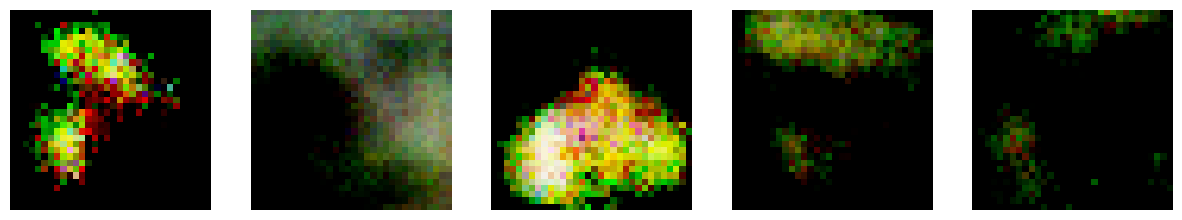

Epoch: [21/300], Batch Num: [0/644]
Discriminator Loss: 0.6711, Generator Loss: 1.4657
D(x): 0.7201, D(G(z)): 0.2050
------------------------------
Epoch: [22/300], Batch Num: [0/644]
Discriminator Loss: 0.8021, Generator Loss: 1.8730
D(x): 0.7820, D(G(z)): 0.2515
------------------------------
Epoch: [23/300], Batch Num: [0/644]
Discriminator Loss: 0.6126, Generator Loss: 2.3931
D(x): 0.8170, D(G(z)): 0.2042
------------------------------
Epoch: [24/300], Batch Num: [0/644]
Discriminator Loss: 0.8975, Generator Loss: 2.1920
D(x): 0.7701, D(G(z)): 0.2355
------------------------------
Epoch: [25/300], Batch Num: [0/644]
Discriminator Loss: 0.4910, Generator Loss: 2.0040
D(x): 0.8424, D(G(z)): 0.2103
------------------------------
Epoch: [26/300], Batch Num: [0/644]
Discriminator Loss: 1.0047, Generator Loss: 1.6656
D(x): 0.6119, D(G(z)): 0.2977
------------------------------
Epoch: [27/300], Batch Num: [0/644]
Discriminator Loss: 0.9096, Generator Loss: 2.6165
D(x): 0.6059, D(G(z)): 0.

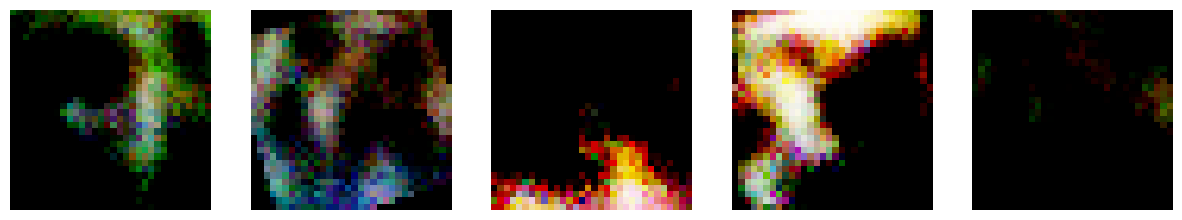

Epoch: [41/300], Batch Num: [0/644]
Discriminator Loss: 1.5558, Generator Loss: 1.3264
D(x): 0.4704, D(G(z)): 0.3720
------------------------------
Epoch: [42/300], Batch Num: [0/644]
Discriminator Loss: 1.0894, Generator Loss: 1.2915
D(x): 0.6063, D(G(z)): 0.3480
------------------------------
Epoch: [43/300], Batch Num: [0/644]
Discriminator Loss: 0.8634, Generator Loss: 1.3165
D(x): 0.7346, D(G(z)): 0.3395
------------------------------
Epoch: [44/300], Batch Num: [0/644]
Discriminator Loss: 1.1148, Generator Loss: 1.1817
D(x): 0.6799, D(G(z)): 0.3956
------------------------------
Epoch: [45/300], Batch Num: [0/644]
Discriminator Loss: 0.9901, Generator Loss: 1.2568
D(x): 0.6303, D(G(z)): 0.3254
------------------------------
Epoch: [46/300], Batch Num: [0/644]
Discriminator Loss: 1.0047, Generator Loss: 1.3111
D(x): 0.6571, D(G(z)): 0.3702
------------------------------
Epoch: [47/300], Batch Num: [0/644]
Discriminator Loss: 0.8559, Generator Loss: 1.1554
D(x): 0.7749, D(G(z)): 0.

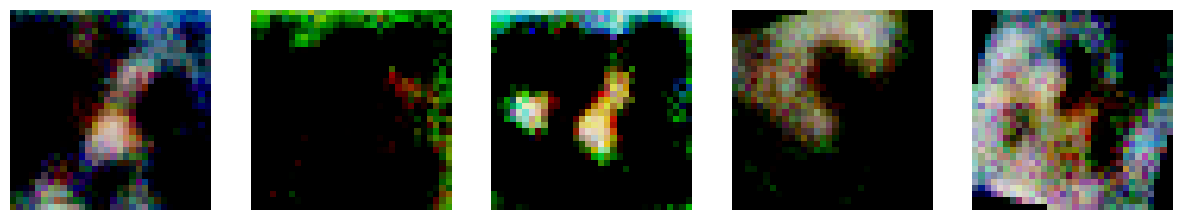

Epoch: [61/300], Batch Num: [0/644]
Discriminator Loss: 1.2203, Generator Loss: 0.9646
D(x): 0.6376, D(G(z)): 0.4222
------------------------------
Epoch: [62/300], Batch Num: [0/644]
Discriminator Loss: 1.1749, Generator Loss: 0.8525
D(x): 0.5289, D(G(z)): 0.3673
------------------------------
Epoch: [63/300], Batch Num: [0/644]
Discriminator Loss: 0.9659, Generator Loss: 1.1895
D(x): 0.7020, D(G(z)): 0.3841
------------------------------
Epoch: [64/300], Batch Num: [0/644]
Discriminator Loss: 1.3150, Generator Loss: 1.0612
D(x): 0.5089, D(G(z)): 0.3988
------------------------------
Epoch: [65/300], Batch Num: [0/644]
Discriminator Loss: 1.1794, Generator Loss: 1.1574
D(x): 0.5243, D(G(z)): 0.3506
------------------------------
Epoch: [66/300], Batch Num: [0/644]
Discriminator Loss: 1.2421, Generator Loss: 0.9845
D(x): 0.5734, D(G(z)): 0.3728
------------------------------
Epoch: [67/300], Batch Num: [0/644]
Discriminator Loss: 1.0992, Generator Loss: 1.3581
D(x): 0.6365, D(G(z)): 0.

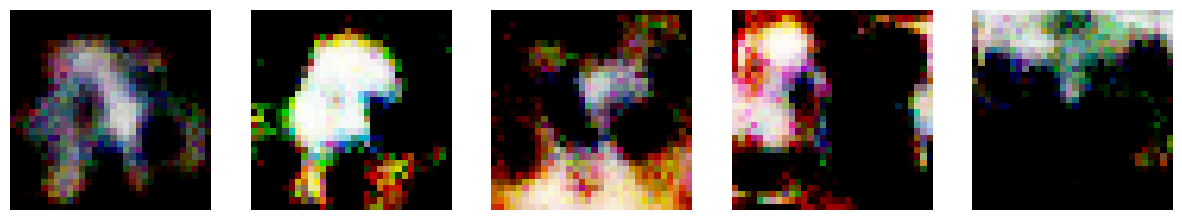

Epoch: [81/300], Batch Num: [0/644]
Discriminator Loss: 1.0092, Generator Loss: 0.9103
D(x): 0.6444, D(G(z)): 0.3742
------------------------------
Epoch: [82/300], Batch Num: [0/644]
Discriminator Loss: 1.1578, Generator Loss: 1.0500
D(x): 0.5655, D(G(z)): 0.3729
------------------------------
Epoch: [83/300], Batch Num: [0/644]
Discriminator Loss: 1.3217, Generator Loss: 1.0065
D(x): 0.5653, D(G(z)): 0.4342
------------------------------
Epoch: [84/300], Batch Num: [0/644]
Discriminator Loss: 1.3038, Generator Loss: 0.9633
D(x): 0.6393, D(G(z)): 0.5021
------------------------------
Epoch: [85/300], Batch Num: [0/644]
Discriminator Loss: 1.1315, Generator Loss: 0.9029
D(x): 0.5718, D(G(z)): 0.3871
------------------------------
Epoch: [86/300], Batch Num: [0/644]
Discriminator Loss: 1.0085, Generator Loss: 0.9820
D(x): 0.6546, D(G(z)): 0.3897
------------------------------
Epoch: [87/300], Batch Num: [0/644]
Discriminator Loss: 1.3080, Generator Loss: 0.9074
D(x): 0.5087, D(G(z)): 0.

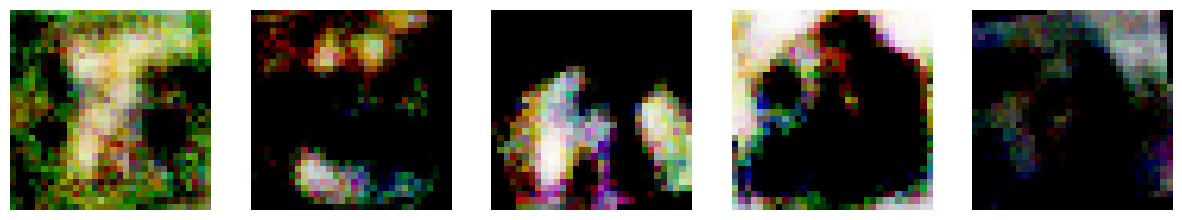

Epoch: [101/300], Batch Num: [0/644]
Discriminator Loss: 1.4292, Generator Loss: 0.8202
D(x): 0.5482, D(G(z)): 0.4996
------------------------------
Epoch: [102/300], Batch Num: [0/644]
Discriminator Loss: 1.1568, Generator Loss: 0.9118
D(x): 0.5925, D(G(z)): 0.4026
------------------------------
Epoch: [103/300], Batch Num: [0/644]
Discriminator Loss: 1.4750, Generator Loss: 0.7958
D(x): 0.5267, D(G(z)): 0.4950
------------------------------
Epoch: [104/300], Batch Num: [0/644]
Discriminator Loss: 1.3902, Generator Loss: 0.8667
D(x): 0.5130, D(G(z)): 0.4843
------------------------------
Epoch: [105/300], Batch Num: [0/644]
Discriminator Loss: 1.2881, Generator Loss: 0.8928
D(x): 0.5301, D(G(z)): 0.4367
------------------------------
Epoch: [106/300], Batch Num: [0/644]
Discriminator Loss: 1.3855, Generator Loss: 0.7738
D(x): 0.5223, D(G(z)): 0.4767
------------------------------
Epoch: [107/300], Batch Num: [0/644]
Discriminator Loss: 1.3908, Generator Loss: 0.8992
D(x): 0.5386, D(G(

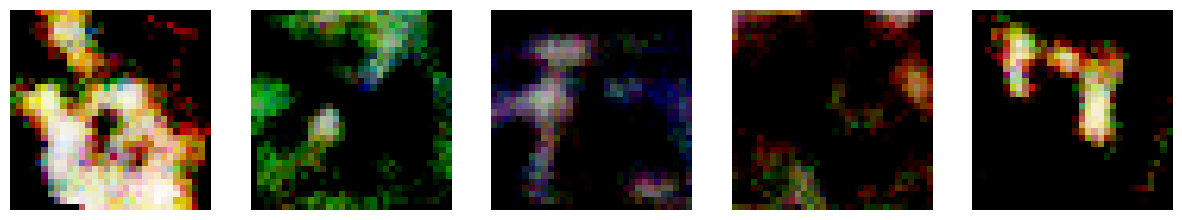

Epoch: [121/300], Batch Num: [0/644]
Discriminator Loss: 1.2380, Generator Loss: 0.7313
D(x): 0.5537, D(G(z)): 0.4402
------------------------------
Epoch: [122/300], Batch Num: [0/644]
Discriminator Loss: 1.1445, Generator Loss: 0.8286
D(x): 0.5616, D(G(z)): 0.3875
------------------------------
Epoch: [123/300], Batch Num: [0/644]
Discriminator Loss: 1.5063, Generator Loss: 0.9499
D(x): 0.5195, D(G(z)): 0.4605
------------------------------
Epoch: [124/300], Batch Num: [0/644]
Discriminator Loss: 1.2562, Generator Loss: 1.0046
D(x): 0.5071, D(G(z)): 0.3625
------------------------------
Epoch: [125/300], Batch Num: [0/644]
Discriminator Loss: 1.1608, Generator Loss: 0.9162
D(x): 0.5864, D(G(z)): 0.4361
------------------------------
Epoch: [126/300], Batch Num: [0/644]
Discriminator Loss: 1.2944, Generator Loss: 0.8707
D(x): 0.5982, D(G(z)): 0.4780
------------------------------
Epoch: [127/300], Batch Num: [0/644]
Discriminator Loss: 1.2617, Generator Loss: 0.9511
D(x): 0.5843, D(G(

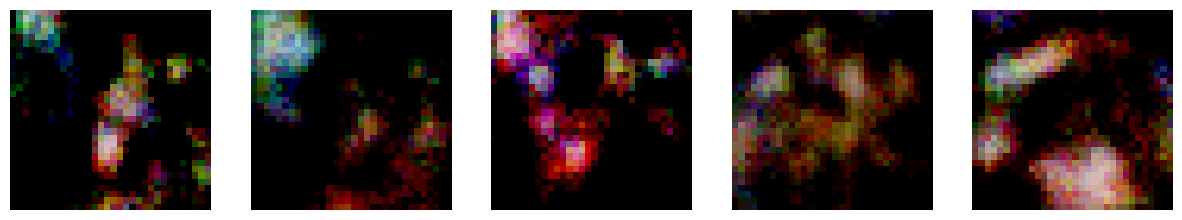

Epoch: [141/300], Batch Num: [0/644]
Discriminator Loss: 1.2665, Generator Loss: 0.8815
D(x): 0.5328, D(G(z)): 0.4328
------------------------------
Epoch: [142/300], Batch Num: [0/644]
Discriminator Loss: 1.2925, Generator Loss: 0.9547
D(x): 0.5533, D(G(z)): 0.4556
------------------------------
Epoch: [143/300], Batch Num: [0/644]
Discriminator Loss: 1.3973, Generator Loss: 0.8991
D(x): 0.5590, D(G(z)): 0.4662
------------------------------
Epoch: [144/300], Batch Num: [0/644]
Discriminator Loss: 1.2531, Generator Loss: 1.0278
D(x): 0.5277, D(G(z)): 0.4290
------------------------------
Epoch: [145/300], Batch Num: [0/644]
Discriminator Loss: 1.2530, Generator Loss: 0.9800
D(x): 0.5313, D(G(z)): 0.4329
------------------------------
Epoch: [146/300], Batch Num: [0/644]
Discriminator Loss: 1.2364, Generator Loss: 0.9128
D(x): 0.5621, D(G(z)): 0.4502
------------------------------
Epoch: [147/300], Batch Num: [0/644]
Discriminator Loss: 1.2633, Generator Loss: 0.8483
D(x): 0.5780, D(G(

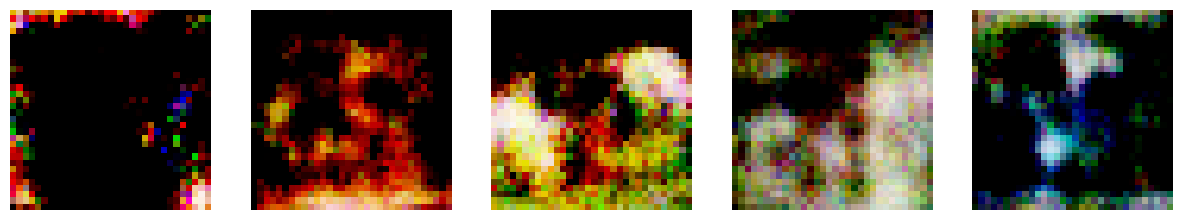

Epoch: [161/300], Batch Num: [0/644]
Discriminator Loss: 1.2450, Generator Loss: 0.9037
D(x): 0.5631, D(G(z)): 0.4590
------------------------------
Epoch: [162/300], Batch Num: [0/644]
Discriminator Loss: 1.3409, Generator Loss: 0.8625
D(x): 0.5356, D(G(z)): 0.4667
------------------------------
Epoch: [163/300], Batch Num: [0/644]
Discriminator Loss: 1.2814, Generator Loss: 0.8374
D(x): 0.4883, D(G(z)): 0.4026
------------------------------
Epoch: [164/300], Batch Num: [0/644]
Discriminator Loss: 1.1521, Generator Loss: 0.8726
D(x): 0.5857, D(G(z)): 0.4182
------------------------------
Epoch: [165/300], Batch Num: [0/644]
Discriminator Loss: 1.3019, Generator Loss: 0.6897
D(x): 0.5303, D(G(z)): 0.4611
------------------------------
Epoch: [166/300], Batch Num: [0/644]
Discriminator Loss: 1.3737, Generator Loss: 0.7523
D(x): 0.5437, D(G(z)): 0.5060
------------------------------
Epoch: [167/300], Batch Num: [0/644]
Discriminator Loss: 1.2863, Generator Loss: 0.9104
D(x): 0.5157, D(G(

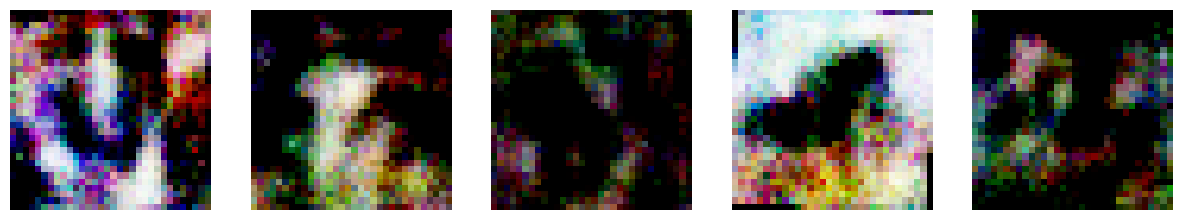

Epoch: [181/300], Batch Num: [0/644]
Discriminator Loss: 1.3070, Generator Loss: 0.7949
D(x): 0.5201, D(G(z)): 0.4526
------------------------------
Epoch: [182/300], Batch Num: [0/644]
Discriminator Loss: 1.3798, Generator Loss: 0.8813
D(x): 0.5536, D(G(z)): 0.4997
------------------------------
Epoch: [183/300], Batch Num: [0/644]
Discriminator Loss: 1.1347, Generator Loss: 0.9226
D(x): 0.6057, D(G(z)): 0.4266
------------------------------
Epoch: [184/300], Batch Num: [0/644]
Discriminator Loss: 1.3131, Generator Loss: 0.8715
D(x): 0.4785, D(G(z)): 0.4213
------------------------------
Epoch: [185/300], Batch Num: [0/644]
Discriminator Loss: 1.2607, Generator Loss: 0.7811
D(x): 0.5468, D(G(z)): 0.4576
------------------------------
Epoch: [186/300], Batch Num: [0/644]
Discriminator Loss: 1.2734, Generator Loss: 0.7321
D(x): 0.5766, D(G(z)): 0.4842
------------------------------
Epoch: [187/300], Batch Num: [0/644]
Discriminator Loss: 1.3731, Generator Loss: 0.8147
D(x): 0.5077, D(G(

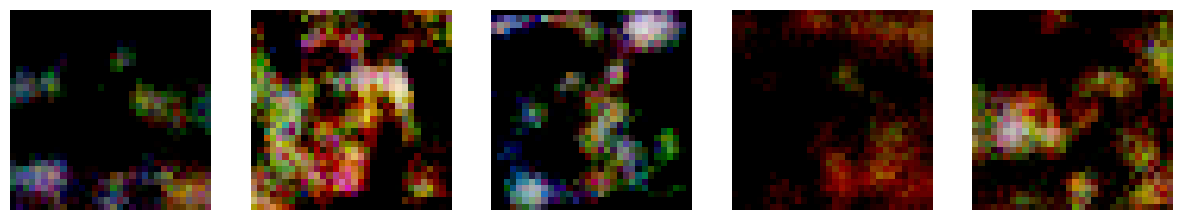

Epoch: [201/300], Batch Num: [0/644]
Discriminator Loss: 1.3906, Generator Loss: 0.8888
D(x): 0.4711, D(G(z)): 0.4451
------------------------------
Epoch: [202/300], Batch Num: [0/644]
Discriminator Loss: 1.2398, Generator Loss: 0.8809
D(x): 0.5591, D(G(z)): 0.4453
------------------------------
Epoch: [203/300], Batch Num: [0/644]
Discriminator Loss: 1.4941, Generator Loss: 0.7650
D(x): 0.5332, D(G(z)): 0.5095
------------------------------
Epoch: [204/300], Batch Num: [0/644]
Discriminator Loss: 1.3356, Generator Loss: 0.7777
D(x): 0.5253, D(G(z)): 0.4605
------------------------------
Epoch: [205/300], Batch Num: [0/644]
Discriminator Loss: 1.1741, Generator Loss: 0.8174
D(x): 0.5820, D(G(z)): 0.4394
------------------------------
Epoch: [206/300], Batch Num: [0/644]
Discriminator Loss: 1.3346, Generator Loss: 0.8186
D(x): 0.4810, D(G(z)): 0.4233
------------------------------
Epoch: [207/300], Batch Num: [0/644]
Discriminator Loss: 1.3378, Generator Loss: 0.8752
D(x): 0.4929, D(G(

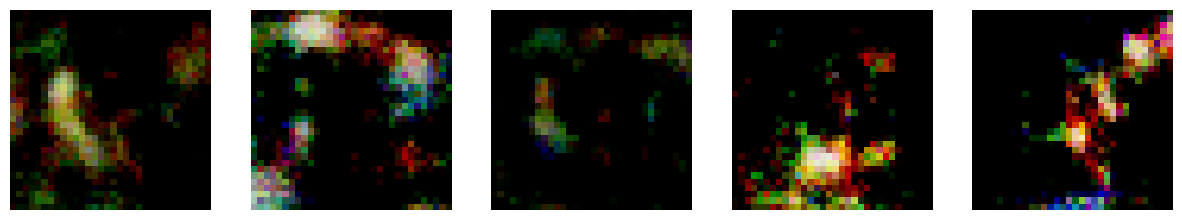

Epoch: [221/300], Batch Num: [0/644]
Discriminator Loss: 1.1621, Generator Loss: 0.8100
D(x): 0.6102, D(G(z)): 0.4571
------------------------------
Epoch: [222/300], Batch Num: [0/644]
Discriminator Loss: 1.3674, Generator Loss: 0.7204
D(x): 0.5230, D(G(z)): 0.4625
------------------------------
Epoch: [223/300], Batch Num: [0/644]
Discriminator Loss: 1.2825, Generator Loss: 0.8080
D(x): 0.6085, D(G(z)): 0.4777
------------------------------
Epoch: [224/300], Batch Num: [0/644]
Discriminator Loss: 1.3099, Generator Loss: 0.8923
D(x): 0.4787, D(G(z)): 0.3816
------------------------------
Epoch: [225/300], Batch Num: [0/644]
Discriminator Loss: 1.2563, Generator Loss: 0.8570
D(x): 0.5994, D(G(z)): 0.4481
------------------------------
Epoch: [226/300], Batch Num: [0/644]
Discriminator Loss: 1.3725, Generator Loss: 0.8152
D(x): 0.5694, D(G(z)): 0.5187
------------------------------
Epoch: [227/300], Batch Num: [0/644]
Discriminator Loss: 1.3880, Generator Loss: 0.8090
D(x): 0.5271, D(G(

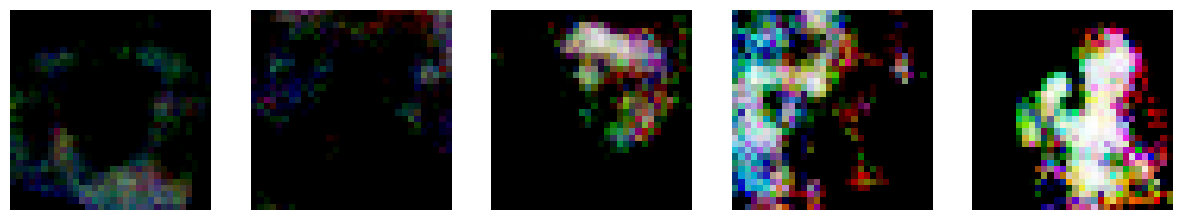

Epoch: [241/300], Batch Num: [0/644]
Discriminator Loss: 1.3309, Generator Loss: 0.8080
D(x): 0.4932, D(G(z)): 0.4276
------------------------------
Epoch: [242/300], Batch Num: [0/644]
Discriminator Loss: 1.2055, Generator Loss: 0.8810
D(x): 0.5328, D(G(z)): 0.4115
------------------------------
Epoch: [243/300], Batch Num: [0/644]
Discriminator Loss: 1.1896, Generator Loss: 0.8608
D(x): 0.5763, D(G(z)): 0.4348
------------------------------
Epoch: [244/300], Batch Num: [0/644]
Discriminator Loss: 1.2725, Generator Loss: 0.7437
D(x): 0.5567, D(G(z)): 0.4716
------------------------------
Epoch: [245/300], Batch Num: [0/644]
Discriminator Loss: 1.3583, Generator Loss: 0.7463
D(x): 0.4878, D(G(z)): 0.4550
------------------------------
Epoch: [246/300], Batch Num: [0/644]
Discriminator Loss: 1.2823, Generator Loss: 0.8330
D(x): 0.5540, D(G(z)): 0.4619
------------------------------
Epoch: [247/300], Batch Num: [0/644]
Discriminator Loss: 1.3580, Generator Loss: 0.8017
D(x): 0.4877, D(G(

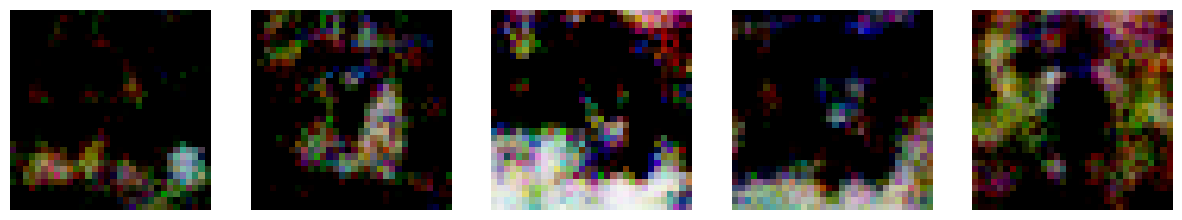

Epoch: [261/300], Batch Num: [0/644]
Discriminator Loss: 1.1534, Generator Loss: 0.9891
D(x): 0.5971, D(G(z)): 0.4291
------------------------------
Epoch: [262/300], Batch Num: [0/644]
Discriminator Loss: 1.1485, Generator Loss: 0.8796
D(x): 0.5891, D(G(z)): 0.4345
------------------------------
Epoch: [263/300], Batch Num: [0/644]
Discriminator Loss: 1.2716, Generator Loss: 0.8723
D(x): 0.5827, D(G(z)): 0.4727
------------------------------
Epoch: [264/300], Batch Num: [0/644]
Discriminator Loss: 1.2838, Generator Loss: 0.7701
D(x): 0.5327, D(G(z)): 0.4507
------------------------------
Epoch: [265/300], Batch Num: [0/644]
Discriminator Loss: 1.2264, Generator Loss: 0.8789
D(x): 0.5672, D(G(z)): 0.4488
------------------------------
Epoch: [266/300], Batch Num: [0/644]
Discriminator Loss: 1.2213, Generator Loss: 0.9399
D(x): 0.6081, D(G(z)): 0.4631
------------------------------
Epoch: [267/300], Batch Num: [0/644]
Discriminator Loss: 1.3962, Generator Loss: 0.8022
D(x): 0.4950, D(G(

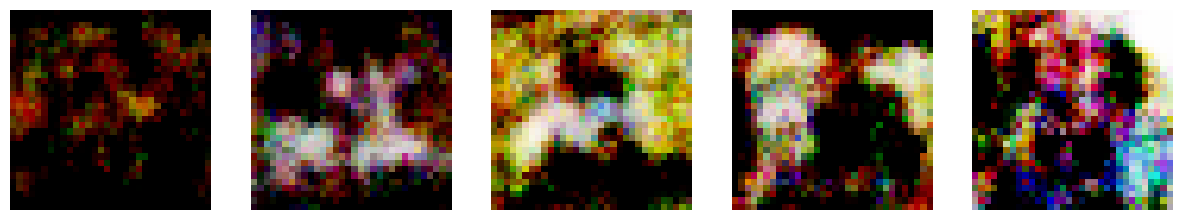

Epoch: [281/300], Batch Num: [0/644]
Discriminator Loss: 1.2921, Generator Loss: 0.7929
D(x): 0.5193, D(G(z)): 0.4413
------------------------------
Epoch: [282/300], Batch Num: [0/644]
Discriminator Loss: 1.3858, Generator Loss: 0.8587
D(x): 0.5547, D(G(z)): 0.4878
------------------------------
Epoch: [283/300], Batch Num: [0/644]
Discriminator Loss: 1.2613, Generator Loss: 0.7767
D(x): 0.5551, D(G(z)): 0.4488
------------------------------
Epoch: [284/300], Batch Num: [0/644]
Discriminator Loss: 1.3126, Generator Loss: 0.8056
D(x): 0.5403, D(G(z)): 0.4513
------------------------------
Epoch: [285/300], Batch Num: [0/644]
Discriminator Loss: 1.2797, Generator Loss: 0.9108
D(x): 0.5362, D(G(z)): 0.4370
------------------------------
Epoch: [286/300], Batch Num: [0/644]
Discriminator Loss: 1.5446, Generator Loss: 0.8032
D(x): 0.5254, D(G(z)): 0.4590
------------------------------
Epoch: [287/300], Batch Num: [0/644]
Discriminator Loss: 1.3616, Generator Loss: 0.7630
D(x): 0.5716, D(G(

In [8]:
        
def train():

    # Models, optimizers and losses
    discriminator = DiscriminatorNet()
    generator = GeneratorNet()
    loss_d = nn.BCELoss()
    loss_g = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), 0.0002)
    g_optimizer = optim.Adam(generator.parameters(), 0.0002)

    data_loader= train_loader
    
    num_epochs=300
    num_batches = len(data_loader)
    
    num_test_samples = 48
    test_noise = noise(num_test_samples)
    z_dim = 100


    for epoch in range(num_epochs):
        for n_batch, data in enumerate(data_loader):

            (real_batch, labels) = data
            N = real_batch.size(0)

            # 1. Train Discriminator
            real_data = real_batch.view(real_batch.size(0), -1)

            # Generate fake data and detach so gradients are not calculated for generator)
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data).detach()

            d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator, d_optimizer, real_data,
                                                                          fake_data,
                                                                          loss_d)
            # 2. Train Generator

            # Generate fake data TO train Generator
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data)
            # Train G
            g_error = train_generator(discriminator, g_optimizer, fake_data, loss_g)  # Log batch error

            
            if n_batch % 644 == 0:
                print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
                            epoch, num_epochs, n_batch, num_batches)
                    )
                print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
                print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))
                print('------------------------------')
        
        if epoch % 20 == 0:
            with torch.no_grad():
                noise2 = torch.randn(25, z_dim)
                generated_images = generator(noise2).cpu().numpy()

            display_transposed_images_single_row(generated_images)
    
train()